# Text Analytics Lab

**Objective**: To demonstrate all of the text analysis techniques covered in this week's lecture material

# 1. Setup

## 1.A Python Setup

In [1]:
# Hack to hide deprecation warnings from included modules
import warnings
def noop(*args, **kargs):
    pass
warnings.warn = noop

import collections
import gensim
import gensim.corpora
import logging
import math
import matplotlib.cm
import matplotlib.pyplot
import msds_utils
import nltk.corpus
import nltk.data
import nltk.help
import nltk.stem
import nltk.tag
import numpy as np
import numpy.random
import pandas as pd
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
import re
import seaborn as sns
import sklearn.compose
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import sklearn.pipeline
import string
import warnings
import wordcloud

%matplotlib inline

pd.set_option('max_row', 100)

# ignore warnings from pyLDAvis
warnings.filterwarnings("ignore", category=DeprecationWarning, append=True) 
warnings.filterwarnings("ignore", category=FutureWarning, append=True)
warnings.simplefilter("ignore")

# Set up logging ... INFO or DEBUG for my code, WARNING for libraries
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger('gensim').setLevel(logging.WARNING)
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

LOGGER = logging.getLogger('Week7')
TOPIC_WORD_REGEX=re.compile(r'(?P<prob>\d+\.\d+)\*\"(?P<word>\w+)\"')

def log_topic_keywords(lda_model, threshold = 0, log_method=LOGGER.info):
    ''' User-defined function to print (log) topic information for a given model
    '''
    
    for topic_id, topic_words in lda_model.print_topics():
        top_words = []
        for match in TOPIC_WORD_REGEX.finditer(topic_words):
            word_probability = float(match.group('prob'))
            word = match.group('word')

            if word_probability > threshold:
                top_words.append(f'{word} ({word_probability:.3f})')

        top_words = ', '.join(top_words)
        log_method(f'{topic_id: >2d}: {top_words}')

## 1.B Data examination

In [2]:
# Examine the file type ... in this case, the CSV file contains multi-line
# content
!file data/assign_wk7/bbc.csv
!wc -l data/assign_wk7/bbc.csv
!head -n 3 data/assign_wk7/bbc.csv

data/assign_wk7/bbc.csv: CSV text
25751 data/assign_wk7/bbc.csv
id,news,type
0,"UK economy facing 'major risks'
 


In [3]:
# Load the file
bbc_df = pd.read_csv('data/assign_wk7/bbc.csv').set_index('id', drop=True, verify_integrity=True)

# Verify the loaded file
df_rows, df_cols = bbc_df.shape
LOGGER.info(f'bbc_df.shape ==> ({df_rows}, {df_cols})')
bbc_df.head()

2021-12-04 19:12:16 - INFO   -      Week7 - bbc_df.shape ==> (2225, 2)


,news,type
id,,
0,UK economy facing 'major risks'\n \n The UK ma...,business
1,Aids and climate top Davos agenda\n \n Climate...,business
2,Asian quake hits European shares\n \n Shares i...,business
3,India power shares jump on debut\n \n Shares i...,business
4,Lacroix label bought by US firm\n \n Luxury go...,business


In [4]:
bbc_df.type.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

In [5]:
bbc_df['news'] = pd.Series(bbc_df.news, dtype='string')
bbc_df['type'] = pd.Series(bbc_df.type, dtype='string')
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   string
 1   type    2225 non-null   string
dtypes: string(2)
memory usage: 52.1 KB


## 1.C Observations

The **`value_counts`** output above gives a hint that the categories used by the BBC itself
consist of
1. ***sport***
2. ***business***
3. ***politics***
4. ***tech***
5. ***entertainment***

# 2 Preparation of the text data for analysis

## 2.1 Elimination of punctuation, digits, lowercase


In [6]:
bbc_df['clean_news'] = bbc_df['news']

bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: x.lower())
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: x.replace('\S+@\S+',''))
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: x.replace('http\S+',''))
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: x.replace('\S+.com',''))
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: x.replace('\S+.edu',''))
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: x.translate(str.maketrans('', '', string.digits)))
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: re.sub('\s+', ' ', x, flags=re.MULTILINE))
bbc_df.head()

,news,type,clean_news
id,,,
0,UK economy facing 'major risks' The UK manu...,business,uk economy facing major risks the uk manufactu...
1,Aids and climate top Davos agenda Climate c...,business,aids and climate top davos agenda climate chan...
2,Asian quake hits European shares Shares in ...,business,asian quake hits european shares shares in eur...
3,India power shares jump on debut Shares in ...,business,india power shares jump on debut shares in ind...
4,Lacroix label bought by US firm Luxury good...,business,lacroix label bought by us firm luxury goods g...


## 2.2 Removal of stopwords

In [7]:
nltk.download('stopwords', quiet=True, raise_on_error=True)

stopwords = nltk.corpus.stopwords.words('english')

bbc_df['stopword_freq'] = bbc_df.clean_news.apply(lambda x: len([x for x in x.split() if x in stopwords]))
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: " ".join(w for w in x.split() if w not in stopwords))
bbc_df.head()


,news,type,clean_news,stopword_freq
id,,,,
0,UK economy facing 'major risks' The UK manu...,business,uk economy facing major risks uk manufacturing...,124
1,Aids and climate top Davos agenda Climate c...,business,aids climate top davos agenda climate change f...,175
2,Asian quake hits European shares Shares in ...,business,asian quake hits european shares shares europe...,192
3,India power shares jump on debut Shares in ...,business,india power shares jump debut shares indias la...,62
4,Lacroix label bought by US firm Luxury good...,business,lacroix label bought us firm luxury goods grou...,51


# 3 Word Frequency

## 3.1 Word frequency - Prior to Lemmatization

### 3.1.1 Identify the 10 most frequently used words in the text


In [8]:
pd.Series(' '.join(bbc_df.clean_news).split()).value_counts().sort_values(ascending=False).head(10)


said      7253
mr        3004
would     2577
also      2156
new       1970
people    1969
us        1923
one       1739
year      1637
could     1510
dtype: int64

### 3.1.2 How about the ten least frequently used words?


In [9]:
pd.Series(' '.join(bbc_df.clean_news).split()).value_counts().sort_values(ascending=True).head(10)

# NOTE:
#     - The word "goodpractice" is actually "good-practice" in the text
#     - Similarly, "wonderstrike" is "wonder-strike"
#     - The "mu" comes from a file extension ".m3u" mentioned in an article
#       about hacking.  When digits were removed, the word became "mu"

mu              1
goodpractice    1
wonderstrike    1
leds            1
jadel           1
ghent           1
soda            1
balkom          1
remotes         1
intranet        1
dtype: int64

## 3.2 Word frequency - After Lemmatization


In [10]:
nltk.download('wordnet', quiet=True, raise_on_error=True)


True

In [11]:
%%bash

# The Lemmatizer incorrectly converts 'us' (i.e., 'US') to 'u'
#
# There are probably many more misleading lemmatizations that should be investigated,
# but I'm considering that out-of-scope for the class (however, US might be significant)

export WORDNET_DIR=${HOME}/nltk_data/corpora/wordnet

if ! grep --quiet --extended-regexp '^(us\s+us)' ${WORDNET_DIR}/noun.exc; then

    # Make a backup of Lemmatizer noun file
    cp ${WORDNET_DIR}/noun.exc  ${WORDNET_DIR}/noun-original.exc

    # Add a translation from 'us' back to 'us' to prevent truncation to 'u' (and re-sort file)
    echo "us us" | sort -o ${WORDNET_DIR}/noun.exc - ${WORDNET_DIR}/noun.exc
fi


In [12]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))
bbc_df.head()


,news,type,clean_news,stopword_freq
id,,,,
0,UK economy facing 'major risks' The UK manu...,business,uk economy facing major risk uk manufacturing ...,124
1,Aids and climate top Davos agenda Climate c...,business,aid climate top davos agenda climate change fi...,175
2,Asian quake hits European shares Shares in ...,business,asian quake hit european share share europe le...,192
3,India power shares jump on debut Shares in ...,business,india power share jump debut share india large...,62
4,Lacroix label bought by US firm Luxury good...,business,lacroix label bought us firm luxury good group...,51


### 3.2.1 Identify the 10 most frequently used words in the text


In [13]:
pd.Series(' '.join(bbc_df.clean_news).split()).value_counts().sort_values(ascending=False).head(10)


said      7253
mr        3045
year      2860
would     2577
also      2156
people    2044
us        2013
new       1970
one       1809
could     1510
dtype: int64

### 3.2.2 How about the ten least frequently used words?


In [14]:
pd.Series(' '.join(bbc_df.clean_news).split()).value_counts().sort_values(ascending=True).head(10)


mu                1
jermoe            1
keino             1
piri              1
weepu             1
foolproof         1
dwyer             1
choke             1
hotlycontested    1
unstuck           1
dtype: int64

## 3.3 Explain and demonstrate how lemmatization changes the most/least frequent words

Lemmatization aims to remove inflectional endings and return the base (or dictionary form) of a word, which is known as the lemma (NLP.Stanford.edu, n.d.).

The table below depicts the top 10 most frequent words before and after lemmatization.
In this particular case, the same words appear in each list, but the counts and ordinal
positions for several words changed.

| Word      | Before lemmatization (position)   | After lemmatization (position)    | Explanation       |
|:----------|:----------------------------------|:----------------------------------|:------------------|
| said      | 7253 (1st)                        | 7253 (1st)                        |                   |
| mr        | 3004 (2nd)                        | **3045** (2nd)                    | mrs               |
| would     | 2577 (3rd)                        | 2577 **(4th)**                    |                   |
| also      | 2156 (4th)                        | 2156 **(5th)**                    |                   |
| new       | 1970 (5th)                        | 1970 **(8th)**                    |                   |
| people    | 1969 (6th)                        | **2044** (6th)                    | peoples, people's |
| us        | 1923 (7th)                        | **2013** (7th)                    | us's              |
| one       | 1739 (8th)                        | **1809** **(9th)**                | one's             |
| year      | 1637 (9th)                        | **2860** **(3rd)**                | years, year's     |
| could     | 1510 (10th)                       | 1510 (10th)                       |                   |

Generally speaking, lemmatization "normalizes" words such that the frequency count for such words are
less affected by choice of a word ending based on grammatical usage.  This means that word counts will
not be splintered across tenses and inflections.

# 4 Generate a world cloud for the text


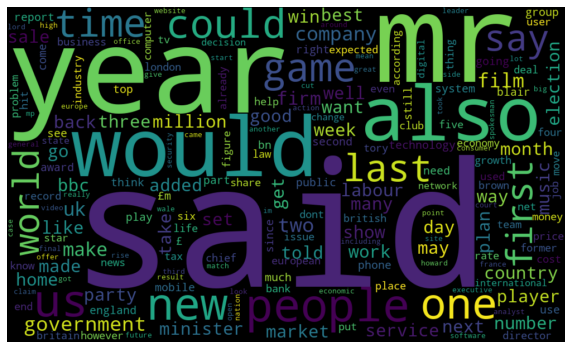

In [15]:
word_freq = pd.Series(' '.join(bbc_df.clean_news).split()).value_counts().to_dict()
wc = wordcloud.WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(word_freq)

matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.imshow(wc, interpolation='bilinear')
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

**NOTE**: Some of the most significant (largest) words like "said", "say", "also, "year"
          don't seem like they should be considered significant (in that they don't
          seem like they would help distinguish between topics).  **More on this later.**

# 5 Demonstrate the generation of n-grams and part of speech tagging

## 5.1 Bigrams

In [16]:
tokens = ' '.join(bbc_df.clean_news).split()


In [17]:
# create bigrams
bbc_bigrams = nltk.bigrams(tokens)

# freq distribution for bigrams
bigram_freq = pd.Series(bbc_bigrams).value_counts().to_dict()
list(bigram_freq.items())[:20]

[(('last', 'year'), 501),
 (('said', 'mr'), 363),
 (('told', 'bbc'), 348),
 (('mr', 'blair'), 335),
 (('prime', 'minister'), 319),
 (('mr', 'brown'), 256),
 (('chief', 'executive'), 206),
 (('said', 'would'), 192),
 (('last', 'week'), 188),
 (('tony', 'blair'), 186),
 (('mobile', 'phone'), 183),
 (('bbc', 'news'), 178),
 (('general', 'election'), 177),
 (('new', 'york'), 167),
 (('six', 'nation'), 162),
 (('mr', 'howard'), 160),
 (('year', 'ago'), 160),
 (('liberal', 'democrat'), 157),
 (('number', 'one'), 147),
 (('first', 'time'), 140)]

## 5.2 Trigrams

In [18]:
# create trigrams
bbc_trigrams = nltk.trigrams(tokens)

# freq distribution for trigrams
trigram_freq = pd.Series(bbc_trigrams).value_counts().to_dict()
list(trigram_freq.items())[:20]

[(('told', 'bbc', 'news'), 147),
 (('bbc', 'news', 'website'), 97),
 (('told', 'bbc', 'radio'), 76),
 (('leader', 'michael', 'howard'), 58),
 (('mr', 'blair', 'said'), 54),
 (('million', 'dollar', 'baby'), 53),
 (('radio', 'today', 'programme'), 49),
 (('told', 'bbc', 'sport'), 48),
 (('bbc', 'radio', 'today'), 47),
 (('mr', 'howard', 'said'), 41),
 (('tory', 'leader', 'michael'), 41),
 (('next', 'general', 'election'), 39),
 (('chancellor', 'gordon', 'brown'), 33),
 (('leader', 'charles', 'kennedy'), 32),
 (('prime', 'minister', 'tony'), 32),
 (('minister', 'tony', 'blair'), 32),
 (('digital', 'music', 'player'), 30),
 (('george', 'w', 'bush'), 29),
 (('two', 'year', 'ago'), 28),
 (('mr', 'blair', 'told'), 27)]

## 5.3 Part of speech (pos) tagging

In [19]:
nltk.download('averaged_perceptron_tagger', quiet=True, raise_on_error=True)
nltk.download('tagsets', quiet=True, raise_on_error=True)
ALL_POS_TAGS = nltk.data.load('help/tagsets/upenn_tagset.pickle')

pos_df = pd.DataFrame(data={'token': tokens, 'POS': [j for i, j in nltk.tag.pos_tag(tokens)]})

pos_df.head()


,token,POS
0,uk,JJ
1,economy,NN
2,facing,VBG
3,major,JJ
4,risk,NN


2021-12-04 19:13:15 - INFO   -      Week7 - The top 15 parts of speech are: 
2021-12-04 19:13:15 - INFO   -      Week7 - POS   NN: 228764 (noun, common, singular or mass)
2021-12-04 19:13:15 - INFO   -      Week7 - POS   JJ:  91681 (adjective or numeral, ordinal)
2021-12-04 19:13:15 - INFO   -      Week7 - POS  VBD:  34500 (verb, past tense)
2021-12-04 19:13:15 - INFO   -      Week7 - POS   RB:  23260 (adverb)
2021-12-04 19:13:15 - INFO   -      Week7 - POS  VBG:  19935 (verb, present participle or gerund)
2021-12-04 19:13:15 - INFO   -      Week7 - POS  VBP:  14677 (verb, present tense, not 3rd person singular)
2021-12-04 19:13:15 - INFO   -      Week7 - POS  VBN:  12853 (verb, past participle)
2021-12-04 19:13:15 - INFO   -      Week7 - POS   VB:  11031 (verb, base form)
2021-12-04 19:13:15 - INFO   -      Week7 - POS  NNS:  10974 (noun, common, plural)
2021-12-04 19:13:15 - INFO   -      Week7 - POS   IN:   7916 (preposition or conjunction, subordinating)
2021-12-04 19:13:15 - INFO 

<AxesSubplot:>

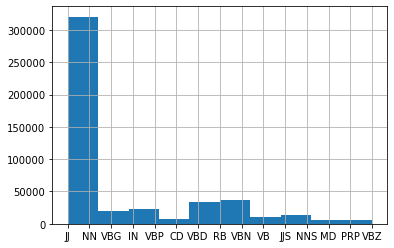

In [20]:
# Out of curiousity, translate some of the POS abbreviations into
# something human-recognizable
TOP_POS_COUNT = 15
pos_value_counts = pos_df.POS.value_counts()
TOP_POS=pos_value_counts.keys()[:TOP_POS_COUNT]

LOGGER.info(f'The top {TOP_POS_COUNT} parts of speech are: ')
for pos in TOP_POS:
    pos_count = pos_value_counts[pos]
    pos_description = ALL_POS_TAGS.get(pos, ['UNKNOWN'])[0]
    LOGGER.info(f'POS {pos: >4}: {pos_count: >6d} ({pos_description})')

pos_df = pos_df[pos_df.POS.isin(TOP_POS)]
pos_df.POS.hist()

# 6 Create a Topic model of the text


In [21]:
# List of "articles", where each article is a list of lemmatized word
lemmatized_articles = bbc_df.clean_news.apply(lambda x: x.split()).to_list()

# Create Dictionary
corpus_dict = gensim.corpora.Dictionary(lemmatized_articles)

# Term Document Frequency Corpus
#
# NOTE: doc2bow: document to bag-of-words
article_tdf_bow = [corpus_dict.doc2bow(article) for article in lemmatized_articles]


In [22]:
# Here, I just want to make sure I understand the data structures...
#
# article_tdf_bow:  a list of articles, where each article is a list of
#                   tuples containing token_id, token_count (token_id
#                   relates back to the word_id dict and token_count is
#                   the count of the token within the given article)
#
# corpus_dict:      a gensim.corpora.Dictionary which maps unique integer
#                   IDs to the lemmatized words from all articles (our
#                   corpus).  The gensim.corpora.Dictionary also contains
#                   attributes and functions useful for revers mapping
#                   and easily retrieving the corpus-wide frequency of
#                   a given word
for article_index in numpy.random.choice(len(article_tdf_bow), size=5):
    for word_index in numpy.random.choice(len(article_tdf_bow[article_index]), size=2):
        word_id, article_word_freq = article_tdf_bow[article_index][word_index]

        # Reverse map from word_id to the lemmatized word
        word = corpus_dict[word_id]

        # Corpus word frequency
        corpus_word_freq =  corpus_dict.cfs[word_id]
        
        LOGGER.info(f'Sanity check: word={word: <15} corpus frequency={corpus_word_freq: >5d} (raw_id={word_id: >5d}, article frequency={article_word_freq: >4d})')

2021-12-04 19:13:17 - INFO   -      Week7 - Sanity check: word=al              corpus frequency=   10 (raw_id= 5484, article frequency=   1)
2021-12-04 19:13:17 - INFO   -      Week7 - Sanity check: word=vast            corpus frequency=   39 (raw_id= 1804, article frequency=   2)
2021-12-04 19:13:17 - INFO   -      Week7 - Sanity check: word=proved          corpus frequency=   76 (raw_id= 2975, article frequency=   1)
2021-12-04 19:13:17 - INFO   -      Week7 - Sanity check: word=slap            corpus frequency=    4 (raw_id=14775, article frequency=   1)
2021-12-04 19:13:17 - INFO   -      Week7 - Sanity check: word=greatest        corpus frequency=   51 (raw_id= 6142, article frequency=   2)
2021-12-04 19:13:17 - INFO   -      Week7 - Sanity check: word=remains         corpus frequency=  124 (raw_id= 1670, article frequency=   1)
2021-12-04 19:13:17 - INFO   -      Week7 - Sanity check: word=deputy          corpus frequency=   76 (raw_id=  720, article frequency=   1)
2021-12-04 19

In [23]:
# Build Basic LDA model
#
# NOTE: I chose 5 as the starting number of topics based on the observation
#       in section 1.C where we found that each BBC article has one of
#       five categories: sport, business, politics, tech, entertainment
INITIAL_TOPICS = 5

lda_model = gensim.models.LdaMulticore(corpus=article_tdf_bow,
                                       id2word=corpus_dict,
                                       num_topics=5, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [24]:
# Print the keywords in the topics
log_topic_keywords(lda_model)


2021-12-04 19:13:23 - INFO   -      Week7 -  0: game (0.012), said (0.011), mobile (0.009), people (0.007), technology (0.006), music (0.006), year (0.006), phone (0.006), new (0.006), also (0.005)
2021-12-04 19:13:23 - INFO   -      Week7 -  1: said (0.009), game (0.006), year (0.005), first (0.004), win (0.004), one (0.004), world (0.004), england (0.004), player (0.004), time (0.004)
2021-12-04 19:13:23 - INFO   -      Week7 -  2: said (0.019), mr (0.013), would (0.008), year (0.006), government (0.006), us (0.005), labour (0.004), also (0.004), party (0.004), minister (0.004)
2021-12-04 19:13:23 - INFO   -      Week7 -  3: said (0.015), people (0.009), user (0.007), software (0.007), system (0.006), firm (0.006), technology (0.006), network (0.005), could (0.005), net (0.005)
2021-12-04 19:13:23 - INFO   -      Week7 -  4: said (0.014), film (0.010), best (0.007), award (0.006), year (0.006), also (0.006), us (0.005), search (0.004), show (0.004), one (0.004)


**NOTE**: The above results match the finding from the word-cloud: it seems that words such as
          "said" and "mr" should perhaps have been removed as stop words.  I'll continue, but
          might need to re-visit

In [25]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model,
                                                   texts=lemmatized_articles,
                                                   dictionary=corpus_dict,
                                                   coherence='c_v')

# retreive the coherence_scores
coherence_lda = coherence_model_lda.get_coherence()

LOGGER.info(f'Coherence Score: {coherence_lda}')                                                   

2021-12-04 19:13:25 - INFO   -      Week7 - Coherence Score: 0.4222816151879674


## 6.1 Find the optimal number of topics

### 6.1.1 Test the accuracy of your model


In [26]:
# range of 2 to 15 topics
MIN_TOPICS=2
MAX_TOPICS=15
COHERENCE_METHOD='c_v'

BEST_FIT = {'num_topics': 0, 'coherence_score': 0, 'model': None}

for i in range(MIN_TOPICS, MAX_TOPICS + 1):
    LOGGER.debug(f'Creating Latent Dirichlet Allocation (LDA) model for {i} topics...')
    lda_model = gensim.models.LdaMulticore(corpus=article_tdf_bow,
                                           id2word=corpus_dict,
                                           num_topics=i, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

    log_topic_keywords(lda_model, log_method=LOGGER.debug)

    LOGGER.debug(f'Calculating LDA coherence score for {i} topics using {COHERENCE_METHOD} coherence algorithm...')
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model,
                                                       texts=lemmatized_articles,
                                                       dictionary=corpus_dict,
                                                       coherence=COHERENCE_METHOD)

    # retrieve the coherence_scores
    coherence_lda = coherence_model_lda.get_coherence()

    LOGGER.info(f'With {i: >2d} topics using {COHERENCE_METHOD: >5s} coherence algorithm... LDA coherence score: {coherence_lda:.3f}')

    if coherence_lda > BEST_FIT['coherence_score']:
        BEST_FIT = {'num_topics': i, 'coherence_score': coherence_lda, 'model': lda_model}

LOGGER.info(f'Best-fit number of topics: {BEST_FIT["num_topics"]} (coherence score: {BEST_FIT["coherence_score"]:.3f})')

2021-12-04 19:13:33 - INFO   -      Week7 - With  2 topics using   c_v coherence algorithm... LDA coherence score: 0.292
2021-12-04 19:13:41 - INFO   -      Week7 - With  3 topics using   c_v coherence algorithm... LDA coherence score: 0.376
2021-12-04 19:13:51 - INFO   -      Week7 - With  4 topics using   c_v coherence algorithm... LDA coherence score: 0.426
2021-12-04 19:14:00 - INFO   -      Week7 - With  5 topics using   c_v coherence algorithm... LDA coherence score: 0.431
2021-12-04 19:14:10 - INFO   -      Week7 - With  6 topics using   c_v coherence algorithm... LDA coherence score: 0.430
2021-12-04 19:14:21 - INFO   -      Week7 - With  7 topics using   c_v coherence algorithm... LDA coherence score: 0.426
2021-12-04 19:14:31 - INFO   -      Week7 - With  8 topics using   c_v coherence algorithm... LDA coherence score: 0.443
2021-12-04 19:14:42 - INFO   -      Week7 - With  9 topics using   c_v coherence algorithm... LDA coherence score: 0.452
2021-12-04 19:14:55 - INFO   -  

### 6.1.2 Display your results 2 different ways

## 6.2 Print the topics and explain any insights at this point

### 6.2.1 Print the topics

In [27]:
# Again, I print the most influential keywords of each topic
# along with their frequency
log_topic_keywords(BEST_FIT['model'], threshold=0.005)


2021-12-04 19:16:11 - INFO   -      Week7 -  0: said (0.013), game (0.011), people (0.010), technology (0.010), mobile (0.009), music (0.007), new (0.007), also (0.006), phone (0.006), digital (0.006)
2021-12-04 19:16:11 - INFO   -      Week7 -  1: said (0.010), game (0.008), first (0.006), win (0.006), time (0.006), year (0.006)
2021-12-04 19:16:11 - INFO   -      Week7 -  2: said (0.018), year (0.014), us (0.012), bn (0.009), sale (0.008), economy (0.008), market (0.008), growth (0.008), price (0.007), bank (0.007)
2021-12-04 19:16:11 - INFO   -      Week7 -  3: mr (0.019), said (0.012), firm (0.009), us (0.009), court (0.006), fraud (0.006)
2021-12-04 19:16:11 - INFO   -      Week7 -  4: said (0.017), search (0.008), would (0.007)
2021-12-04 19:16:11 - INFO   -      Week7 -  5: mr (0.023), said (0.021), would (0.011), labour (0.010), party (0.010), election (0.009), government (0.008), blair (0.008), minister (0.007), tory (0.007)
2021-12-04 19:16:11 - INFO   -      Week7 -  6: irel

In [28]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(BEST_FIT['model'], article_tdf_bow, corpus_dict)
pyLDAvis.save_html(LDAvis_prepared, 'topic_model_viz.html')

/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

### 6.2.2 Explain any insights at this point

**Finding**: Again, some of the most frequently occurring words don't seem significant.

## 6.3 Analysis using additional stopwords

### 6.3.1 Apply addional stopwords and re-evaluate optimal number of topics

In [29]:
additional_stopwords = ['said', 'say', 'mr', 'also', 'would', 'could', 'people', 'year', 'told', 'first', 'last', 'one', 'use', 'new', 'two', 'get', 'b', 'c', 'g', 'j', 'm', 'p', 'r', 'v']
bbc_df['clean_news'] = bbc_df.clean_news.apply(lambda x: " ".join(w for w in x.split() if w not in additional_stopwords))


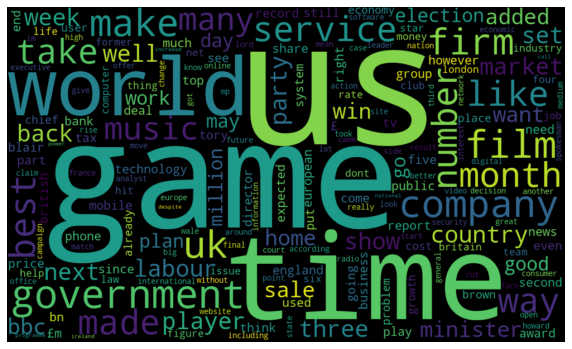

In [30]:
# Updated word-cloud after removing additional stopwords
word_freq = pd.Series(' '.join(bbc_df.clean_news).split()).value_counts().to_dict()
wc = wordcloud.WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(word_freq)

matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.imshow(wc, interpolation='bilinear')
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [31]:
# List of "articles", where each article is a list of lemmatized word
lemmatized_articles = bbc_df.clean_news.apply(lambda x: x.split()).to_list()

# Create Dictionary
corpus_dict = gensim.corpora.Dictionary(lemmatized_articles)

# Term Document Frequency Corpus
#
# NOTE: doc2bow: document to bag-of-words
article_tdf_bow = [corpus_dict.doc2bow(article) for article in lemmatized_articles]

# range of 2 to 15 topics
MIN_TOPICS=2
MAX_TOPICS=15
COHERENCE_METHOD='c_v'
MIN_PROBABILITY = 0.001 # arbitrary cutoff for display
BEST_FIT_2 = {'num_topics': 0, 'coherence_score': 0, 'model': None}

for i in range(MIN_TOPICS, MAX_TOPICS + 1):
    LOGGER.debug(f'Creating Latent Dirichlet Allocation (LDA) model for {i} topics...')
    lda_model = gensim.models.LdaMulticore(corpus=article_tdf_bow,
                                           id2word=corpus_dict,
                                           num_topics=i, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

    log_topic_keywords(lda_model, threshold=MIN_PROBABILITY, log_method=LOGGER.debug)

    LOGGER.debug(f'Calculating LDA coherence score for {i} topics using {COHERENCE_METHOD} coherence algorithm...')
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model,
                                                       texts=lemmatized_articles,
                                                       dictionary=corpus_dict,
                                                       coherence=COHERENCE_METHOD)

    # retreive the coherence_scores
    coherence_lda = coherence_model_lda.get_coherence()

    LOGGER.info(f'With {i: >2d} topics using {COHERENCE_METHOD: >5s} coherence algorithm... LDA coherence score: {coherence_lda:.3f}')

    if coherence_lda > BEST_FIT_2['coherence_score']:
        BEST_FIT_2 = {'num_topics': i, 'coherence_score': coherence_lda, 'model': lda_model}

LOGGER.info(f'Best-fit (after adjusting stopwords) number of topics: {BEST_FIT_2["num_topics"]} (coherence score: {BEST_FIT_2["coherence_score"]:.3f})')

topic_delta = BEST_FIT_2["num_topics"] - BEST_FIT["num_topics"]
coherence_delta = BEST_FIT_2["coherence_score"] - BEST_FIT["coherence_score"]
LOGGER.info(f'Best-fit delta: Num Topics before={BEST_FIT["num_topics"]}, after={BEST_FIT_2["num_topics"]} (delta: {topic_delta}) ... Coherence score before={BEST_FIT["coherence_score"]:.3f}, after={BEST_FIT_2["coherence_score"]:.3f} (delta: {coherence_delta:.3f})')

2021-12-04 19:16:26 - INFO   -      Week7 - With  2 topics using   c_v coherence algorithm... LDA coherence score: 0.386
2021-12-04 19:16:35 - INFO   -      Week7 - With  3 topics using   c_v coherence algorithm... LDA coherence score: 0.402
2021-12-04 19:16:46 - INFO   -      Week7 - With  4 topics using   c_v coherence algorithm... LDA coherence score: 0.525
2021-12-04 19:16:55 - INFO   -      Week7 - With  5 topics using   c_v coherence algorithm... LDA coherence score: 0.612
2021-12-04 19:17:06 - INFO   -      Week7 - With  6 topics using   c_v coherence algorithm... LDA coherence score: 0.545
2021-12-04 19:17:17 - INFO   -      Week7 - With  7 topics using   c_v coherence algorithm... LDA coherence score: 0.498
2021-12-04 19:17:27 - INFO   -      Week7 - With  8 topics using   c_v coherence algorithm... LDA coherence score: 0.543
2021-12-04 19:17:39 - INFO   -      Week7 - With  9 topics using   c_v coherence algorithm... LDA coherence score: 0.554
2021-12-04 19:17:55 - INFO   -  

**As theorized**, we see a significant improvement in coherence score by removing extraneous words.

### 6.3.2 Print the topics

In [32]:
log_topic_keywords(BEST_FIT_2['model'])

2021-12-04 19:19:26 - INFO   -      Week7 -  0: software (0.009), site (0.008), firm (0.008), user (0.007), system (0.007), security (0.007), computer (0.006), program (0.006), email (0.006), net (0.006)
2021-12-04 19:19:26 - INFO   -      Week7 -  1: game (0.010), mobile (0.009), technology (0.007), phone (0.007), music (0.006), digital (0.005), service (0.004), player (0.004), video (0.004), time (0.004)
2021-12-04 19:19:26 - INFO   -      Week7 -  2: best (0.005), film (0.005), game (0.005), win (0.004), time (0.004), world (0.004), award (0.004), player (0.004), england (0.004), back (0.003)
2021-12-04 19:19:26 - INFO   -      Week7 -  3: government (0.007), labour (0.006), party (0.006), election (0.005), minister (0.005), blair (0.004), tory (0.004), plan (0.003), public (0.003), us (0.003)
2021-12-04 19:19:26 - INFO   -      Week7 -  4: us (0.008), company (0.007), market (0.007), bn (0.006), firm (0.005), price (0.005), sale (0.005), growth (0.005), economy (0.005), share (0.00

### 6.3.3 Graph the topics 

<Figure size 720x720 with 0 Axes>

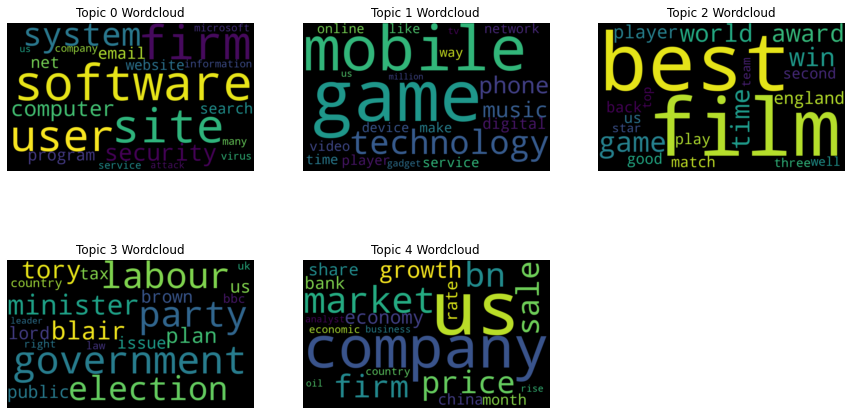

In [33]:
matplotlib.pyplot.figure(figsize=(10, 10))

topics = BEST_FIT_2['model'].print_topics(num_words=20)
figure_cols = 3
figure_rows = int(math.ceil(len(topics) / figure_cols))

# A personal figure size preference, based on the number or rows and cols:
matplotlib.pyplot.figure(figsize=(5.0 * figure_cols, 4.0 * figure_rows))

for topic_id, topic_words in topics:
    frequencies = {}
    for match in TOPIC_WORD_REGEX.finditer(topic_words):
        word_probability = float(match.group('prob'))
        word = match.group('word')

        frequencies[word] = word_probability

        ax = matplotlib.pyplot.subplot(figure_rows,
                                       figure_cols,
                                       topic_id + 1,
                                       title=f'Topic {topic_id} Wordcloud')

    wc = wordcloud.WordCloud(width=1000, height=600, max_words=20).generate_from_frequencies(frequencies)
    matplotlib.pyplot.imshow(wc, interpolation='bilinear')
    matplotlib.pyplot.axis('off')
    
matplotlib.pyplot.show()


In [34]:
LDAvis_prepared = pyLDAvis.gensim_models.prepare(BEST_FIT_2['model'], article_tdf_bow, corpus_dict)
pyLDAvis.save_html(LDAvis_prepared, 'topic_model_viz_2.html')

## 7 Insights and Conclusion

In the wordclouds above, we can begin to distinguish the original BBC topics identified in
section **1.C**.  But, the LDA analysis has not identified a topic specifically for ***sport***
(perhaps it is subsumed in entertainment, Topic 2) and has identified two topics that
appear to address technology.

1. ***sport*** (Topic 2?)
2. ***business*** (Topic 4)
3. ***politics*** (Topic 3)
4. ***tech*** (Topics 0, 1)
5. ***entertainment*** (Topic 2)

# References

* NLP.Stanford.Edu (n.d.)  Stemming and lemmatization.  Retrieved from https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html